In [1]:
# Scientific libraries
import scipy
import pylab
import numpy as np
import numpy.ma as ma
from nmf import nmf

# Audio libraries
from scipy.io import wavfile
from IPython.display import display, Audio

# Operational libraries
import os
import matplotlib.pylab as plt
%matplotlib inline

## Read in the data

In [2]:
audio_dir = "/Users/kni/Code/Magnolia/data/sisec-dev/"
fs, snda = wavfile.read(os.path.join(audio_dir, "dev_Ca1_Ce_A_src.wav"))
fs, sndb = wavfile.read(os.path.join(audio_dir, "dev_Ca1_Ce_B_src.wav"))

sndab = snda+sndb

## Utility Functions and Non-negative Matrix Factorization

In [3]:
def stft(x, fs, framesz, hop):
    '''
    Short Time Fourier Transform (STFT) - Spectral decomposition
    
    Input:
        x = signal (1-d array, which is amp/sample)
        fs = sampling frequency (in Hz)
        framesz = frame size (in seconds)
        hop = skip length (in seconds)
        
    Output:
        X = 2d array, window by number of windows
    '''
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = scipy.hanning(framesamp)
    X = scipy.array([scipy.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

def istft(X, fs, T, hop):
    ''' Inverse Short Time Fourier Transform (iSTFT) - Spectral reconstruction
    
    Input:
        X = set of 2D windows
        fs = sampling frequency (in Hz)
        T = total length of reconstruction willing to be performed
        hop = skip rate
    '''
    x = scipy.zeros(T*fs)
    framesamp = X.shape[1]
    hopsamp = int(hop*fs)
    for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
        x[i:i+framesamp] += scipy.real(scipy.ifft(X[n]))
    return x

## Spectral transform and component decomposition

The decomposition below fits a model:

$$ \| X - WH \|_F^2 + \alpha \lambda_1 \| W \|_1 + \alpha \lambda_1 \| H \|_1  $$

Unfortunately, the code below only stores $W$, and leaves the user to calculate $H$

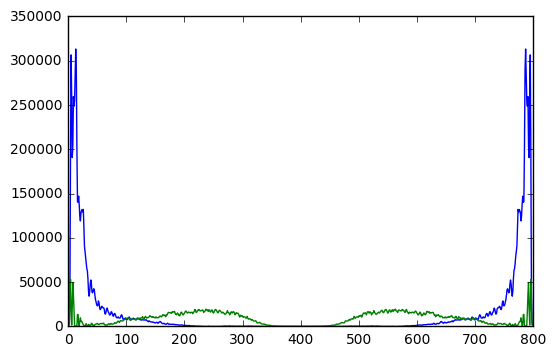

In [4]:
sndabft = stft( sndab, fs, 0.05, 0.025)
W,H = nmf(abs(sndabft),2)

plt.plot( H.T )

## Reconstruction (first Fourier and time-domain)

Based on the spectral decomposition in the above cell, where



In [16]:
print( W.T.shape )
print( wi.shape )

(2, 398)
(2,)


In [20]:
ws = W.T
masks = np.zeros((len(W.T),) + sndabft.shape)
for i,wi in enumerate(W.T):
    ws[i]= wi / np.linalg.norm(wi)
    energyi = ws[i].dot(abs(sndabft).T)
    masks[i] = np.outer( energyi, ws[i] )
    
maska = (masks[0]) > (masks[1])
maskb = (masks[1]) > (masks[0])

plt.figure();
plt.subplot(211); plt.plot( ws[0].dot(abs(sndabft).T)/1e5 )
plt.subplot(212); plt.plot( ws[1].dot(abs(sndabft).T)/1e5 )
plt.figure(); plt.imshow(maska.T, aspect=.2, cmap='bone')
plt.figure(); plt.imshow(maskb.T, aspect=.2, cmap='bone')

ValueError: shapes (398,) and (800,398) not aligned: 398 (dim 0) != 800 (dim 0)

In [21]:
sndareconft = maska*abs(sndabft)*np.exp( 1j* np.angle(sndabft))  # Apply mask A
sndarecon = istft( sndareconft, fs, 5, 0.025 )

sndbreconft = maskb*abs(sndabft)*np.exp( 1j* np.angle(sndabft))  # Apply mask B = 1 - A
sndbrecon = istft( sndbreconft, fs, 5, 0.025 )

NameError: name 'maska' is not defined

## Play audio

In [ ]:
print('Original signal')
display(Audio(sndab, rate=fs))
print('Reconstruction of signal A')
display(Audio(sndarecon,rate=fs))
print('Reconstruction of signal B')
display(Audio(sndbrecon,rate=fs))